# Pancancer Boxplot for PTEN trans effect on MCM2

This notebook creates a boxplot for the trans effect of PTEN cnv deletions in 8 cancers. These 8 cancers were chosen because they have enough samples with PTEN cnv deletions to do a t-test. Only Ccrcc does not have enough samples with deletions. 

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import sys
import plot_utils as p

Functions:

format_df prepares a data frame with PTEN proteomics and PTEN mutation types from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [31]:
# Returns a dataframe with proteomics and mutation type

def format_df(cancer_object, trans_gene, gene_in = 'PTEN'):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = trans_gene)
        prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples
        
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = u.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    else: 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2=trans_gene)
        omics = u.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns='PTEN_CNV')
        # Get only tumor samples
        p = cancer_object.get_proteomics(tissue_type='tumor')
        tumor_ids = list(p.index)
        get = omics.index.isin(tumor_ids)
        omics = omics[get]
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        del_wt['Mutation'] = np.where(
            del_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')

    return del_wt


In [3]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


In [20]:
def pval_status(pval, cancer_object):
    cancer_name = cancer_object.get_cancer_type()
    #print(cancer_name)
    
    sig = False
    if cancer_name == 'gbm':
        if pval <=  0.008466960:
            sig = True
    elif cancer_name == 'hnscc':
        if pval <= 0.002243254:
            sig = True         
    elif cancer_name == 'luad':
        if pval <= 0.0005181887:
            sig = True        
    elif cancer_name == 'lscc':
        if pval <= 0.001318396:
            sig = True        
    elif cancer_name == 'brca':
        if pval <= 0.000004:
            sig = True
    elif cancer_name == 'ovarian':
        if pval <= 1.058914e-08:
            sig = True        
    elif cancer_name == 'endometrial':
        if pval <= 0.001925357:
            sig = True
    # all test were not sig for colon
    elif cancer_name == 'colon':
        sig = False
    #print(sig)
    return sig

# Step 1: Create a dictionary of the status of signficance for a gene 

First, load in cancer data sets from cptac. 

In [9]:
en = cptac.Endometrial()
h = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 2)


cptac warning: The LUAD dataset is under publication embargo until July 01, 2020. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)


cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 7)


In [11]:
root = R'~\Github\WhenMutationsDontMatter\PTEN\Step_3_trans_effect\csv'
sig_df = pd.read_csv(root+R'\sig_pval_heatmap.csv')

In [81]:
gene = 'MCM2'
gene_df = sig_df.loc[sig_df['Proteomics'] == gene]
gene_df = gene_df[['P_Value','Cancer']]
pval_dict = pd.Series(gene_df.P_Value.values,index=gene_df.Cancer).to_dict()
print(pval_dict)

sig_dict = {}
cancer_list = ['Gbm','Hnscc','Lscc','Luad','Brca','Ov','En','Colon']
cancer_objects = {'Gbm':g,'Hnscc':h,'Lscc':ls,'Luad':l,'Brca':b,'Ov':o,'En':en,'Colon':col}
for cancer in cancer_list:
    #print(cancer_objects[cancer])
    new = pval_status(pval_dict[cancer], cancer_objects[cancer])
    sig_dict[cancer] = new
sig_dict

{'Gbm': 4.136722462609951e-05, 'Hnscc': 0.0010519593414552784, 'Luad': 0.18631618561116026, 'Lscc': 9.288714937148975e-05, 'Brca': 0.1023641772877795, 'Ov': 0.3679054265511873, 'En': 0.007643232628875406, 'Colon': 0.8561694177212431}


{'Gbm': True,
 'Hnscc': True,
 'Lscc': True,
 'Luad': False,
 'Brca': False,
 'Ov': False,
 'En': False,
 'Colon': False}

# Step 2: Create data frames with PTEN cnv deletion and Proteomics

Each cancer needs a data frame containing only samples that have PTEN cnv deletions or PTEN wildtype tumors and PTEN proteomics. Use format_df to create the specific data frame for each cancer.  

# Gbm

In [29]:
gene = 'PTEN'
t_gene = 'MCM2'
g_del_wt = format_df(g, t_gene)
print(g_del_wt.head())

cols = list(g_del_wt.columns[:-1])
g_pval = u.wrap_ttest(g_del_wt, 'Mutation', cols, return_all = True)
gp = g_pval['P_Value'][0]
g_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 311)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 311)


Name        MCM2_proteomics  Mutation
Patient_ID                           
C3L-00104          0.865204  Deletion
C3L-00365          0.943165  Deletion
C3L-00674         -0.236399  Deletion
C3L-00677         -0.093372  Deletion
C3L-01040         -0.957693  Deletion


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


,Comparison,P_Value
0,MCM2_proteomics,0.000041


# Luad

In [32]:
l_del_wt = format_df(l, t_gene)

# t-test
cols = list(l_del_wt.columns[:-1])
l_pval = u.wrap_ttest(l_del_wt, 'Mutation', cols, return_all = True)
lp = l_pval['P_Value'][0]
l_pval

cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-00001.N, C3L-00009.N, C3L-00080.N, C3L-00083.N, C3L-00093.N, C3L-00094.N, C3L-00095.N, C3L-00140.N, C3L-00144.N, C3L-00263.N, C3L-00279.N, C3L-00368.N, C3L-00412.N, C3L-00422.N, C3L-00510.N, C3L-00604.N, C3L-00893.N, C3L-00913.N, C3L-00973.N, C3L-01330.N, C3L-01632.N, C3L-01682.N, C3L-01683.N, C3L-01889.N, C3L-01890, C3L-01890.N, C3L-01924.N, C3L-02219.N, C3L-02345.N, C3L-02348.N, C3L-02350.N, C3L-02365.N, C3L-02508.N, C3L-02549.N, C3N-00167.N, C3N-00169.N, C3N-00175.N, C3N-00180.N, C3N-00199.N, C3N-00203.N, C3N-00217.N, C3N-00223.N, C3N-00293.N, C3N-00433.N, C3N-00546.N, C3N-00547.N, C3N-00549.N, C3N-00550.N, C3N-00551.N, C3N-00552.N, C3N-00556.N, C3N-00559.N, C3N-00560.N, C3N-00572.N, C3N-00574.N, C3N-00578.N, C3N-00579.N, C3N-00580.N, C3N-00704.N, C3N-00737.N, C3N-00738.N, C3N-00959.N, C3N-01016.N, C3N-01021.N, C3N-01023.N, C3N-01024.N, C3N-01030.N, C3N-01

,Comparison,P_Value
0,MCM2_proteomics,0.186316


# Lscc

In [33]:
ls_del_wt = format_df(ls, t_gene)

# t-test
cols = list(ls_del_wt.columns[:-1])
ls_pval = u.wrap_ttest(ls_del_wt, 'Mutation', cols, return_all = True)
lsp = ls_pval['P_Value'][0]
ls_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 99 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 311)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 201 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


,Comparison,P_Value
0,MCM2_proteomics,0.000093


# Ovarian

In [34]:
o_del_wt = format_df(o, t_gene)

# t-test
cols = list(o_del_wt.columns[:-1])
o_pval = u.wrap_ttest(o_del_wt, 'Mutation', cols, return_all = True)
op = o_pval['P_Value'][0]
o_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 98 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 311)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 01OV029, 02OV015 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 311)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 99 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


,Comparison,P_Value
0,MCM2_proteomics,0.367905


# Brca

In [36]:
b_del_wt = format_df(b, t_gene)

# t-test
cols = list(b_del_wt.columns[:-1])
b_pval = u.wrap_ttest(b_del_wt, 'Mutation', cols, return_all = True)
bp = b_pval['P_Value'][0]
b_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 113 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 311)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 113 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


,Comparison,P_Value
0,MCM2_proteomics,0.102364


# Colon

In [35]:
c_del_wt = format_df(col, t_gene)

# t-test
cols = list(c_del_wt.columns[:-1])
c_pval = u.wrap_ttest(c_del_wt, 'Mutation', cols, return_all = True)
cp = c_pval['P_Value'][0]
c_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 311)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 311)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 201 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)
cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: 01CO001, 05CO005, 05CO007, 05CO014, 05

,Comparison,P_Value
0,MCM2_proteomics,0.856169


#  Hnscc

In [37]:
h_del_wt = format_df(h, t_gene)

# t-test
cols = list(h_del_wt.columns[:-1])
h_pval = u.wrap_ttest(h_del_wt, 'Mutation', cols, return_all = True)
hp = h_pval['P_Value'][0]
h_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 109 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 311)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-02617, C3N-02727 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 311)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 176 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


,Comparison,P_Value
0,MCM2_proteomics,0.001052


# Endometrial

The Endometrial data set does not have enough cnv deletions to perform a t-test, however the data set does have enough truncation type mutations (nonsense and frame shifts). Different code is needed to create the data frame for Endometrial.

In [38]:
# Step 1 - Create proteomics and truncations dataframe
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = t_gene, 
    mutations_filter = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins']) 
keep = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins','Wildtype_Tumor']
in_keep = prot_and_mutations['PTEN_Mutation'].isin(keep)
trunc_mutations = prot_and_mutations[in_keep]
print(trunc_mutations['PTEN_Mutation'].value_counts())

# Step 2 - Create binary column 
trunc_mutations['Mutation'] = np.where(
            trunc_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')

# Step 3 - Format the dataframe correctly for the t-test(just omics and binary columns for tumors)
tumors = trunc_mutations[trunc_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
e_trunc_wt = tumors.drop(columns_to_drop, axis = 1)
e_trunc_wt = e_trunc_wt.dropna(axis=1,how='all')
e_trunc_wt['Mutation'].value_counts()

# t-test
cols = list(e_trunc_wt.columns[:-1])
e_pval = u.wrap_ttest(e_trunc_wt, 'Mutation', cols, return_all=True)
ep = e_pval['P_Value'][0]
e_pval

Nonsense_Mutation    25
Frame_Shift_Del      22
Wildtype_Tumor       20
Frame_Shift_Ins       6
Name: PTEN_Mutation, dtype: int64


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Comparison,P_Value
0,MCM2_proteomics,0.004337


# Step 2: Create a long dataframe for the boxplot

The boxplot will take three columns: Proteomics, Mutation, and Cancer. We need to append all the individual cancer dfs into one long pancancer df. 

First create the Cancer column.

In [39]:
g_del_wt = g_del_wt.assign(cancer = 'Gbm')
l_del_wt = l_del_wt.assign(cancer = 'Luad')
ls_del_wt = ls_del_wt.assign(cancer = 'Lscc')
b_del_wt = b_del_wt.assign(cancer = 'Brca')
o_del_wt = o_del_wt.assign(cancer = 'Ovarian')
c_del_wt = c_del_wt.assign(cancer = 'Colon')
h_del_wt = h_del_wt.assign(cancer = 'Hnscc') # higher scale
e_trunc_wt = e_trunc_wt.assign(cancer = 'Endometrial')

Next append the dfs.

In [128]:
df = g_del_wt.append(l_del_wt)
df2 = df.append(ls_del_wt)
df3 = df2.append(b_del_wt)
df4 = df3.append(o_del_wt)
df5 = df4.append(c_del_wt)
df6 = df5.append(e_trunc_wt)
#df7 = df6.append(h_del_wt) # Leave out Hnscc because of high proteomics numbers

df6.cancer.unique()

array(['Gbm', 'Luad', 'Lscc', 'Brca', 'Ovarian', 'Colon', 'Endometrial'],
      dtype=object)

# Step 3: Create the Pancancer Boxplot

p-values:
{'Gbm': 4.136722462609951e-05, 'Hnscc': 0.0010519593414552784, 'Luad': 0.18631618561116026, 'Lscc': 9.288714937148975e-05, 'Brca': 0.1023641772877795, 'Ov': 0.3679054265511873, 'En': 0.007643232628875406, 'Colon': 0.8561694177212431}


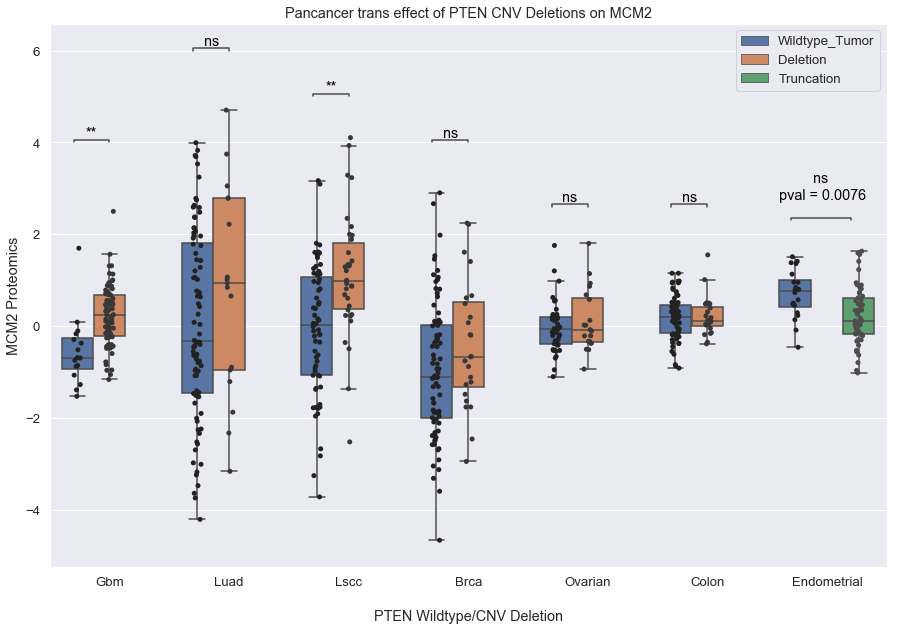

In [127]:
gene = 'PTEN'
plt.rcParams['figure.figsize']=(15,10) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='cancer', y=t_gene+"_proteomics", data = df6, hue = 'Mutation',
                      hue_order = ["Wildtype_Tumor", "Deletion",'Truncation'], showfliers = False)    
boxplot.set_title('Pancancer trans effect of PTEN CNV Deletions on '+t_gene)
boxplot = sns.stripplot(x='cancer', y=t_gene+"_proteomics", data = df6, jitter = True, 
                           color = ".3", hue = 'Mutation', hue_order = ["Wildtype_Tumor", "Deletion", 'Truncation'],dodge = True)
boxplot.set(xlabel = "\n"+gene+" Wildtype/CNV Deletion", ylabel = t_gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])

# create pval annotations
symbols = {}
for cancer in cancer_list:
    val = str(pval_dict[cancer])
    if sig_dict[cancer] == True:
        if pval_dict[cancer]  <= 0.00001:
            symbols[cancer] = '***'
        elif pval_dict[cancer]  <= 0.0001:
            symbols[cancer] = '**'  
        else: # <= 0.001
            symbols[cancer] = '*'
    else:
        symbols[cancer] = 'ns'
print('p-values:\n'+str(pval_dict))

format_pval_annotation(symbols['Gbm'], -.3, 0, 4) # Gbm
format_pval_annotation(symbols['Luad'], .7, 1, 6) # Luad
format_pval_annotation(symbols['Lscc'], 1.7, 2, 5) # Lscc
format_pval_annotation(symbols['Brca'], 2.7, 3, 4) # Brca
format_pval_annotation(symbols['Ov'], 3.7, 4, 2.6) # Ovarian
format_pval_annotation(symbols['Colon'], 4.7, 5, 2.6)  # Colon
format_pval_annotation(symbols['En']+'\n pval = '+str(pval_dict['En'])[:6]+'\n', 5.7, 6.2, 2.3) # Endometrial

plt.show()
plt.clf()
plt.close()

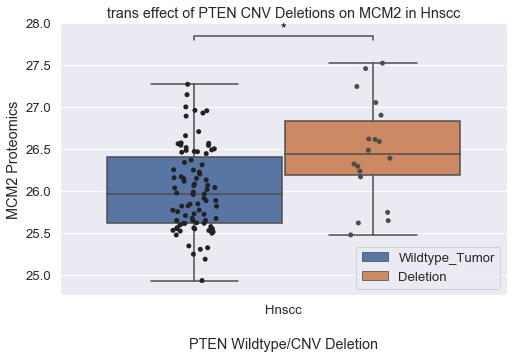

In [142]:
# Figure for Hnscc (higher scale)
gene = 'PTEN'
plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='cancer', y=t_gene+"_proteomics", data = h_del_wt, hue = 'Mutation',
                      hue_order = ["Wildtype_Tumor", "Deletion"], showfliers = False)    
boxplot.set_title('trans effect of PTEN CNV Deletions on '+t_gene+' in Hnscc')
boxplot = sns.stripplot(x='cancer', y=t_gene+"_proteomics", data = h_del_wt, jitter = True, 
                           color = ".3", hue = 'Mutation', hue_order = ["Wildtype_Tumor", "Deletion"],dodge = True)
boxplot.set(xlabel = "\n"+gene+" Wildtype/CNV Deletion", ylabel = t_gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

format_pval_annotation(symbols['Hnscc'], -.2, .2, 27.8) 

plt.show()
plt.clf()
plt.close()

In [17]:
# Save figure
#fig = boxplot.get_figure()
#fig.savefig(".png")